In [1]:
from ase.build import nanotube
from ase.visualize import view
#cnt = nanotube(6, 0, length=4)
#cnt.rotate([1,0,0], [0,0,1])
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp

In [2]:
from ase.cluster.cubic import FaceCenteredCubic
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [6, 9, 5]
lc = 3.61000
atoms = nanotube(5, 3, length=2)
atoms.rotate((1,0,0), (0,0,1), rotate_cell=True)
atoms.center(about=0.)
print(atoms.positions.min(0))
print(atoms.positions.max(0))

[-29.71857143  -2.73869679  -2.74010461]
[29.71857143  2.73869679  2.74010461]


In [3]:
def Gaussian2D(x, y, A, xc, yc, sigma):
    return A*np.exp(
        -(
            (x-xc)**2 + 
            (y-yc)**2
        )/(2*sigma**2))

def Gaussian2DCupy(x, y, A, xc, yc, sigma):
    return A*cp.exp(
        -(
            (x-xc)**2 + 
            (y-yc)**2
        )/(2*sigma**2))

def SympyGaussian2D(x, y, A, xc, yc, sigma):
    return A*sp.exp(
        -(
            (x-xc)**2 + 
            (y-yc)**2
        )/(2*sigma**2))

def rotation_matrix(deg):
    c = np.cos(np.deg2rad(deg))
    s = np.sin(np.deg2rad(deg))
    return np.array([[c, -s],[s, c]])

def rotation_matrix_cupy(deg):
    c = cp.cos(cp.deg2rad(deg))
    s = cp.sin(cp.deg2rad(deg))
    return np.array([[c, -s],[s, c]])

def meshgridCupy(x, y):
    X = np.tile(x[:, None], len(y)).T
    Y = np.tile(y[:, None], len(x))

class ImageModel:
    margin = 3
    power = 1.8

    def __init__(
        self, 
        atoms=None, positions=None, numbers=None,
        pixel_size=0.1, sigma=0.2, power=1.8, scan_rotation = 0, square = False):
        if atoms:
            self.atom_positions = atoms.positions[:,:2]
            self.atom_numbers = atoms.numbers
        else:
            self.atom_positions = positions
            self.atom_numbers = numbers
        self.number_of_atoms = len(self.atom_numbers)
        self.pixel_size = pixel_size
        self.sigma = sigma
        self.scan_rotation = scan_rotation
        self.square = square
        

        
        self.create_probe_positions()
        self.create_probe_positions_cupy()
        self.create_parameters()
        self.create_parameters_cupy()
        
    def init_sympy(self):
        xy = sp.symbols('x y')
        parameters = sp.symbols('A xc yc sigma', cls=sp.IndexedBase)
        i,n = sp.symbols("i n", integer=True)
        self.symbols = xy + parameters + (n,)
        A, xc, yc, sigma = parameters
        
        Gauss = SympyGaussian2D(*xy, A[i], xc[i], yc[i], sigma[i])
        model = sp.Sum(Gauss, (i,0,n-1))
        self.model = model

    def create_probe_positions(self):
        xlow, ylow = self.atom_positions.min(0) - self.margin
        xhigh, yhigh = self.atom_positions.max(0) + self.margin
        scale = (xhigh - xlow)/100

        if self.square:
            xlow = ylow = min(xlow, ylow)
            xhigh = yhigh = max(xhigh, yhigh)
        xrange = np.arange(xlow, xhigh+scale, self.pixel_size)
        yrange = np.arange(ylow, yhigh+scale, self.pixel_size)
        X, Y = np.meshgrid(xrange, yrange)
        if self.scan_rotation:
            mean = np.array([X.mean(), Y.mean()])[:, None]
            self.probe_positions = (
                rotation_matrix(self.scan_rotation) @ (
                    np.array([X.flatten(), Y.flatten()]) - mean 
                ) + mean).reshape((2, *X.shape))
        else:
            self.probe_positions = np.array((X,Y))
    
    def create_probe_positions_cupy(self):
        xlow, ylow = self.atom_positions.min(0) - self.margin
        xhigh, yhigh = self.atom_positions.max(0) + self.margin
        scale = (xhigh - xlow)/100

        if self.square:
            xlow = ylow = min(xlow, ylow)
            xhigh = yhigh = max(xhigh, yhigh)
        xrange = cp.arange(xlow, xhigh+scale, self.pixel_size)
        yrange = cp.arange(ylow, yhigh+scale, self.pixel_size)
        X, Y = cp.meshgrid(xrange, yrange)
        if self.scan_rotation:
            mean = cp.array([X.mean(), Y.mean()])[:, None]
            self.probe_positions_cupy = (
                rotation_matrix_cupy(self.scan_rotation) @ (
                    np.array([X.flatten(), Y.flatten()]) - mean 
                ) + mean).reshape((2, *X.shape))
        else:
            self.probe_positions_cupy = (X,Y)
    
    def create_parameters(self):
        xc, yc = self.atom_positions.T
        A = self.atom_numbers ** self.power
        sigma = np.ones(self.number_of_atoms) * self.sigma #* 2.355 # 2.355 from fwhm -> sigma conversion
        self.parameters = np.array([A, xc, yc, sigma])
        
    def create_parameters_cupy(self):
        self.parameters_cupy = cp.array(self.parameters)
        
    def generate_lambdify(self):
        self.init_sympy()
        func = sp.lambdify(self.symbols, self.model, modules = 'numpy')
        self.func = func
        return func(*self.probe_positions, *self.parameters, self.number_of_atoms)
    
    def generate_lambdify_cupy(self):
        self.init_sympy()
        func = sp.lambdify(self.symbols, self.model, modules = 'cupy')
        self.func_cupy = func
        return func(*self.probe_positions_cupy, *self.parameters_cupy, self.number_of_atoms)
    
    def generate_cupy(self):
        X, Y = self.probe_positions_cupy
        img = cp.zeros(X.shape)
        #As, XC, YC, SIGMA = self.parameters_cupy
        for parameters in self.parameters_cupy.T:
            gauss = Gaussian2DCupy(X, Y, *parameters)
            img += gauss
        return img
 
    def generate_cupy_ram(self):
        X, Y = self.probe_positions_cupy
        img = cp.sum(Gaussian2DCupy(X[..., None], Y[..., None], *self.parameters_cupy), -1)
        return img
    
    def generate_numpy(self):
        img = np.zeros(self.probe_positions[0].shape)
        for parameters in self.parameters.T:
            gauss = Gaussian2D(*self.probe_positions, *parameters)
            img += gauss
        return img
    
    def generate_numpy_ram(self):
        X, Y = self.probe_positions
        img = np.zeros(X.shape)
        img = np.sum(Gaussian2D(X[..., None], Y[..., None], *self.parameters), -1)
        return img
    
    def generate_crop(self):
        X, Y = self.probe_positions
        img = np.zeros(X.shape)
        _, xc, yc, _ = self.parameters
        radius = 5 * self.sigma
        masks = np.logical_and.reduce(
            (X[..., None] > xc - radius, 
             X[..., None] < xc + radius, 
             Y[..., None] > yc - radius, 
             Y[..., None] < yc + radius))
        masks = masks.swapaxes(-2, -1).swapaxes(-2, -3)
        img = np.zeros(X.shape)
        for mask, parameters in zip(masks, self.parameters.T):
            gauss = Gaussian2D(X[mask], Y[mask], *parameters)
            img[mask] += gauss
        return img
    
    def generate_crop_cupy(self):
        X, Y = self.probe_positions_cupy
        img = cp.zeros(X.shape)
        radius = 5 * self.sigma
        _, xc, yc, _ = self.parameters_cupy
        maskx = cp.logical_and(
            X[..., None] > xc - radius, 
            X[..., None] < xc + radius)
        masky = cp.logical_and(
            Y[..., None] > yc - radius, 
            Y[..., None] < yc + radius)     
        
        masks = cp.logical_and(maskx, masky)
        masks = masks.swapaxes(-2, -1).swapaxes(-2, -3)
        img = cp.zeros(X.shape)
        for mask, parameters in zip(masks, self.parameters_cupy.T):
            gauss = Gaussian2D(X[mask], Y[mask], *parameters)
            img[mask] += gauss
        return img

    def generate_crop_cupy2(self):
        X, Y = self.probe_positions_cupy
        img = cp.zeros(X.shape)
        radius = 5 * self.sigma
        img = cp.zeros(X.shape)
        for parameters in self.parameters_cupy.T:
            _, xc, yc, _ = parameters
            maskx = cp.logical_and(
                X > xc - radius,
                X < xc + radius)
            masky = cp.logical_and(
                Y > yc - radius,
                Y < yc + radius)
            mask = cp.logical_and(maskx, masky)
            gauss = Gaussian2D(X[mask], Y[mask], *parameters)
            img[mask] += gauss
        return img

In [62]:
A, B = np.random.random((2,5,5))
np.array([A, B]) == np.stack([np.array([1]), np.array([2])])

array([[ True],
       [ True]])

In [55]:
C = cp.random.random((2,5,5))
A, B = C

In [56]:
cp.testing.assert_array_almost_equal(cp.stack([A,B]), C)

In [19]:
np.meshgrid(np.arange(5), np.arange(5))

[array([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]]), array([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4]])]

In [10]:
m = ImageModel(atoms, )
m.generate_lambdify();
m.generate_lambdify_cupy();

hi
hi


In [5]:
# img1 = m.generate_cupy()
# img2 = m.generate_cupy_ram()
# img3 = m.generate_numpy()
# img4 = m.generate_numpy_ram()
# img5 = m.generate_lambdify()
# img6 = m.generate_lambdify_cupy()
# img7 = m.generate_crop()
# img8 = m.generate_crop_cupy()

# imgs = [cp.asnumpy(img1), cp.asnumpy(img2), img3, img4, img5, cp.asnumpy(img6), img7, cp.asnumpy(img8), ]

In [6]:
cp.cuda.device

<module 'cupy.cuda.device' from 'C:\\Users\\thomasaar\\Miniconda3\\envs\\cupy\\lib\\site-packages\\cupy\\cuda\\device.cp37-win_amd64.pyd'>

In [7]:
import cupy as cp
cp.cuda.get_cuda_path()

In [10]:
%time img1 = m.generate_cupy()
%time img2 = m.generate_cupy_ram()

%time img3 = m.generate_numpy()
%time img4 = m.generate_numpy_ram()

%time img5 = m.generate_lambdify()
%time img6 = m.generate_lambdify_cupy()

%time img7 = m.generate_crop()
%time img8 = m.generate_crop_cupy()

%time img9 = m.generate_crop_cupy2()

Wall time: 153 ms
Wall time: 0 ns
Wall time: 904 ms
Wall time: 1.62 s
Wall time: 940 ms
Wall time: 120 ms
Wall time: 846 ms
Wall time: 382 ms
Wall time: 411 ms


(2, 122, 661)

In [18]:
probe_positions_shape = np.shape(m.probe_positions)
noise = (2*np.random.random(probe_positions_shape)-1) * 0.1



In [176]:
%time img7 = m.generate_crop()


Wall time: 1min 59s


In [11]:
# #%time img1 = m.generate_cupy()
# #%time img2 = m.generate_cupy_ram()

# %time img3 = m.generate_numpy()
# %time img4 = m.generate_numpy_ram()

# %time img5 = m.generate_lambdify()
# %time img6 = m.generate_lambdify_cupy()

# %time img7 = m.generate_crop()
# %time img8 = m.generate_crop_cupy()

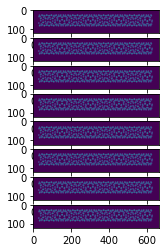

In [12]:
fig, AX = plt.subplots(nrows=len(imgs))
for i, ax in enumerate(AX):
    ax.imshow(imgs[i])

In [35]:
type(img6)

cupy.core.core.ndarray

In [73]:
m.parameters[3]

0.2

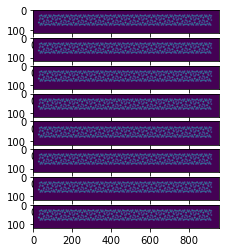

In [130]:
for img in imgs[1:]:
    print(np.abs(img - imgs[0]).sum())

1.5810100733066133e-11
1.5810100733066133e-11
3.428633325893796e-11
2.4604949954790326e-11


In [129]:
%matplotlib widget

In [116]:
pixel_size = 0.1
scan_rotation = 0
square = True

xlow, ylow, zlow = atoms.positions.min(0) - 3
xhigh, yhigh, zhigh = atoms.positions.max(0) + 3
scale = (xhigh - xlow)/100

if square:
    xlow = ylow = min(xlow, ylow)
    xhigh = yhigh = max(xhigh, yhigh)
xrange = np.arange(xlow, xhigh+scale, pixel_size)
yrange = np.arange(ylow, yhigh+scale, pixel_size)
X, Y = np.meshgrid(xrange, yrange)
mean = np.array([X.mean(), Y.mean()])[:, None]
X, Y = (
    rotation_matrix(scan_rotation) @ (
        np.array([X.flatten(), Y.flatten()]) - mean 
    ) + mean).reshape((2, *X.shape))



In [121]:
m = ImageModel(atoms, 0.01)
img = m.generate_cupy()

In [124]:
from PIL import Image
im = Image.fromarray(img.astype("uint16"))
im.save(f'nanotube.tif')

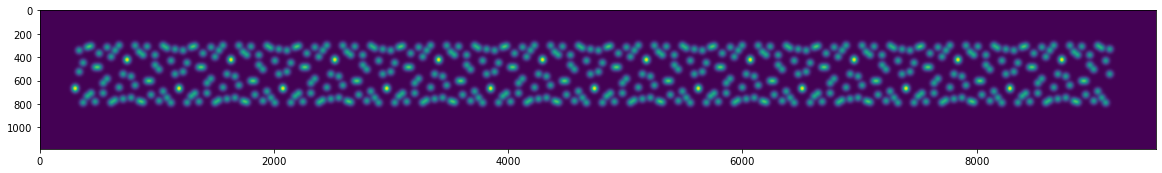

In [122]:
plt.figure(figsize = (20,5))
plt.imshow(img)

In [95]:
@jit(nopython=True, parallel=True)
def numpyloop(X, Y, numbers, positions):
    img = np.zeros(X.shape)
    for number, position in zip(numbers, positions):
        gauss = Gaussian2D(X, Y, 5, position[0], position[1], 0.2)
        img += gauss

In [73]:
%%timeit
numpyloop(X, Y, atoms.numbers, atoms.positions)

1 loop, best of 5: 18.7 s per loop


In [108]:
def cupyloop(atoms):
    img = cp.zeros(X.shape)
    for number, position in zip(atoms.numbers, atoms.positions):
        gauss = Gaussian2DCupy(X, Y, number**1.8, position[0], position[1], 0.2)
        img += gauss
    return cp.asnumpy(img)

In [105]:
X2 = cp.array(X)
Y2 = cp.array(Y)
numbers, positions = cp.array(atoms.numbers), cp.array(atoms.positions)


In [107]:
%%time
img = cupyloop(X2, Y2, numbers, positions)

Wall time: 765 ms


In [101]:
img.shape

(953, 953)

ValueError: object __array__ method not producing an array

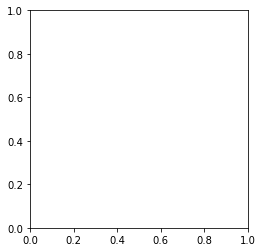

In [100]:
plt.figure()
plt.imshow(img)

In [54]:
m = ImageModel(atoms, 0.1, 0, True)

In [55]:
img2 = m.generate()


In [381]:
from ase.build import stack, make_supercell
a = make_supercell(atoms, np.diag([3,3,3]))

In [382]:
view(a)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img)

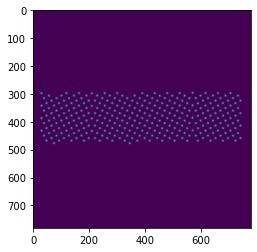

In [374]:
img /= img.max()
img *= 200 
img += np.random.poisson(img)
plt.figure()
plt.imshow(img)
im = Image.fromarray(img.astype("uint16"))
im.save(f'grains.tif')

-47.16894930482619 -47.16894930482619
47.1689493048262 47.1689493048262
-47.16894930482619 -47.16894930482619
47.1689493048262 47.1689493048262
-47.16894930482619 -47.16894930482619
47.1689493048262 47.1689493048262
-47.16894930482619 -47.16894930482619
47.1689493048262 47.1689493048262
-47.16894930482619 -47.16894930482619
47.1689493048262 47.1689493048262
-47.16894930482619 -47.16894930482619
47.1689493048262 47.1689493048262
-47.16894930482619 -47.16894930482619
47.1689493048262 47.1689493048262
-47.16894930482619 -47.16894930482619
47.1689493048262 47.1689493048262


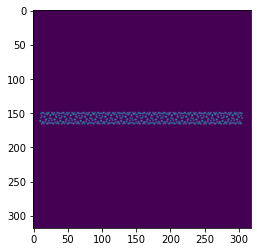

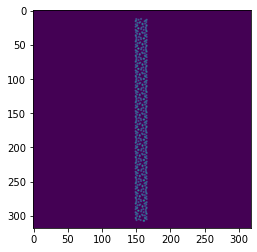

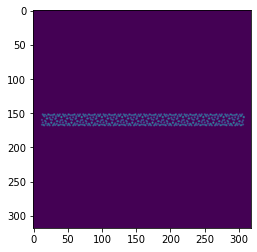

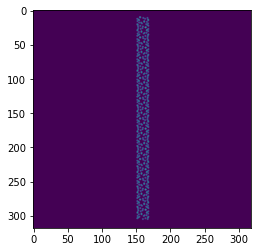

In [355]:
for i, rot in (enumerate([0, 90, 180, 270])):
    m.scan_rotation = rot
    img = m.generate()
    #img = np.rot90(img, i, (1,0))
    img /= img.max()
    img *= 200 
    img += np.random.poisson(img)
    plt.figure()
    plt.imshow(img)
    im = Image.fromarray(img.astype("uint16"))
    im.save(f'Rot2_{i}.tif')

In [271]:
from PIL import Image

AttributeError: 'Image' object has no attribute 'astype'

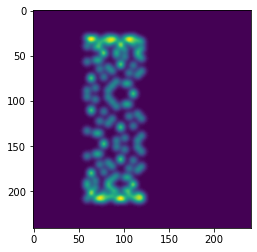

In [277]:
plt.figure()

plt.imshow(img)


In [200]:

def rot(deg):
    rm = rotation_matrix(deg)
    x,y = m.positions()
    return np.einsum('ji, mni -> jmn', rm, np.dstack([x, y]))

In [97]:
r = rot(20)

In [ ]:
x,y = 

[[5.08090229]
 [5.08190592]]


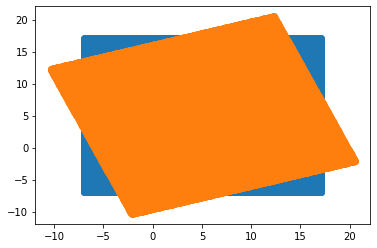

In [198]:
plt.figure()
x, y = m.positions()
plt.scatter(x,y)


mean = np.array([x.mean(), y.mean()])[:, None]
print(mean)
x, y = (rotation_matrix(20) @ (np.array([x.flatten(), y.flatten()]) - mean ) + mean).reshape((2, *x.shape))
plt.scatter(x,y)

#x, y = r
#plt.scatter(x,y)

In [129]:
pixel_size = 1
xlow, ylow, zlow = atoms.positions.min(0) - 3
xhigh, yhigh, zhigh = atoms.positions.max(0) + 3
scale = (xhigh - xlow)/100

xrange = np.arange(xlow, xhigh+pixel_size, pixel_size)
yrange = np.arange(ylow, yhigh+pixel_size, pixel_size)

In [132]:
xrange

array([-6.96909771, -5.96909771, -4.96909771, -3.96909771, -2.96909771,
       -1.96909771, -0.96909771,  0.03090229,  1.03090229,  2.03090229,
        3.03090229,  4.03090229,  5.03090229,  6.03090229,  7.03090229,
        8.03090229,  9.03090229, 10.03090229, 11.03090229, 12.03090229,
       13.03090229, 14.03090229, 15.03090229, 16.03090229, 17.03090229])

In [141]:
xrange = np.array([1,2,3,4])
np.tile(xrange, 4)

array([1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4])

In [38]:
xrange = np.random.random(500)
yrange = np.random.random(300)

In [47]:
%%timeit



1000 loops, best of 5: 1.11 ms per loop


In [48]:
%%timeit
X2, Y2 = np.meshgrid(xrange,yrange)

1000 loops, best of 5: 673 µs per loop


In [46]:
np.testing.assert_almost_equal(Y, Y2)

In [42]:
X.shape

(500, 300)

In [32]:
Y.shape

(500, 500)

In [33]:
X.shape

(500, 500)

In [182]:
%%timeit
x1, y1 = np.meshgrid(xrange, yrange)
x1, y1 = x1.flatten(), y1.flatten()

100 loops, best of 5: 2.26 ms per loop


In [178]:
print(x1.flatten())
print(y1.flatten())

[1 2 3 1 2 3]
[3 3 3 4 4 4]


In [ ]:
%%timeit
x = xrange.copy()
np.tile(x[:, None], 4).flatten()

In [188]:
x,y = m.positions()

def func(deg, x, y):
    x, y = (rotation_matrix(deg) @ np.array([x.flatten(), y.flatten()])).reshape((2, *x.shape))
    return (x,y)

def rot(deg, x, y):
    rm = rotation_matrix(deg)
    return np.einsum('ji, mni -> jmn', rm, np.dstack([x, y]))

In [189]:
%timeit func(20, x.copy(), y.copy())
%timeit rot(20, x.copy(), y.copy())

1000 loops, best of 5: 739 µs per loop
1000 loops, best of 5: 828 µs per loop


In [77]:
def DoRotation(xspan, yspan, RotRad=0):
    """Generate a meshgrid and rotate it by RotRad radians."""

    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(RotRad),  np.sin(RotRad)],
                          [-np.sin(RotRad), np.cos(RotRad)]])

    x, y = np.meshgrid(xspan, yspan)
    return np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([x, y]))

In [49]:
m = ImageModel(atoms)

In [50]:
img = m.generate()

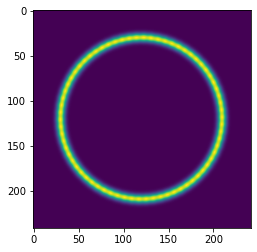

In [51]:
plt.figure()
plt.imshow(img)

In [56]:
rotation_matrix(20) @ (x, y)
Z = np.array([X.flatten(), Y.flatten()])

In [65]:
Z2 = rotation_matrix(20) @ Z

In [66]:
X2, Y2 = Z2
#X2 = X2.reshape(X.shape)
#Y2 = Y2.reshape(X.shape)

In [76]:
plt.figure()
plt.hist2d(X.flatten(), Y.flatten(), 100, range=((-10, 30), (-10, 30)))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
         -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
          0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
          4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
          8. ,   8.4,   8.8,   9.2,   9.6,  10. ,  10.4,  10.8,  11.2,
         11.6,  12. ,  12.4,  12.8,  13.2,  13.6,  14. ,  14.4,  14.8,
         15.2,  15.6,  16. ,  16.4,  16.8,  17.2,  17.6,  18. ,  18.4,
         18.8,  19.2,  19.6,  20. ,  20.4,  20.8,  21.2,  21.6,  22. ,
         22.4,  22.8,  23.2,  23.6,  24. ,  24.4,  24.8,  25.2,  25.6,
         26. ,  26.4,  26.8,  27.2,  27.6

In [77]:
plt.figure()
plt.hist2d(X2, Y2, 100, range=((-10, 30), (-10, 30)))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
         -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
          0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
          4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
          8. ,   8.4,   8.8,   9.2,   9.6,  10. ,  10.4,  10.8,  11.2,
         11.6,  12. ,  12.4,  12.8,  13.2,  13.6,  14. ,  14.4,  14.8,
         15.2,  15.6,  16. ,  16.4,  16.8,  17.2,  17.6,  18. ,  18.4,
         18.8,  19.2,  19.6,  20. ,  20.4,  20.8,  21.2,  21.6,  22. ,
         22.4,  22.8,  23.2,  23.6,  24. ,  24.4,  24.8,  25.2,  25.6,
         26. ,  26.4,  26.8,  27.2,  27.6

In [69]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(X2, Y2)
plt.axis('equal')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-13.122601133695714,
 26.647742911128393,
 -5.629282459978048,
 33.62188922817492)

In [38]:
model = ImageModel(cell)
for scale in [0.12]:
    model.pixel_size = scale
    img = model.generate()
    plt.figure()
    plt.imshow(img)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
import atomap.api as am

/home/thomasaar/miniconda3/envs/py/lib/python3.8/site-packages/pyUSID/viz/__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


In [8]:
import hyperspy.api as hs

In [9]:
s = hs.signals.Signal2D(img)

In [10]:
s_peaks = am.get_feature_separation(s, separation_range=(2, 20))


[########################################] | 100% Completed |  0.1s


In [11]:
s_peaks.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
atom_positions = am.get_atom_positions(s, separation=5)

In [13]:
sublattice = am.Sublattice(atom_positions, image=s.data)

In [35]:
import numpy as np
np.array(data)

In [14]:
sublattice.find_nearest_neighbors()
sublattice.refine_atom_positions_using_center_of_mass()
sublattice.refine_atom_positions_using_2d_gaussian()

In [15]:
 points_x, points_y = sublattice.atom_positions.T

In [16]:
from atomap.tools import remove_integrated_edge_cells

integrated_intensity, intensity_record, point_record = am.integrate(s, points_x, points_y)
ii, ir, pr = remove_integrated_edge_cells(integrated_intensity, intensity_record, point_record, edge_pixels=1)

In [19]:
pr.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
def probe_positions(model, drift_vector, scale=None, scannoise=True, xlen=None, ylen=None, start: "(x,y)"=None):
    if xlen == None or ylen == None:
        xlen, ylen = m.axes_manager.signal_shape
    if scale == None:
        scale = s.axes_manager[-1].scale
    if start == None:
        start = [ax.offset for ax in m.axes_manager.signal_axes]
    X = np.zeros((ylen, xlen))
    Y = np.zeros((ylen, xlen))
    
    xdrift = 0
    ydrift = 0

    if scannoise == True:
        xnoise = np.random.random() * 0.1
    elif scannoise == False:
        xnoise = 0
    else:
        xnoise = scannoise
    
    for yi in range(ylen):
        xnoise = np.random.random() * 0.1 # flyback noise

        for xi in range(xlen):
            xdrift -= drift_vector[0]
            ydrift -= drift_vector[1]

            X[yi, xi] = xi*scale + start[0] + xdrift*scale + xnoise
            Y[yi, xi] = yi*scale + start[1] + ydrift*scale
    return X, Y


In [59]:
x, y = sp.symbols('x y')

def Gaussian2D(A, xc, yc, sigma):
    return A*sp.exp(
        -(
            (x-xc)**2 + 
            (y-yc)**2
        )/(2*sigma**2))

parameters = []
s = 0.3
for atom in cell:
    x0, y0, z0 = atom.position
    A = atom.number**1.8
    
    parameters.append([A, x0, y0, s])
model = sum([Gaussian2D(*symb) for symb in parameters])

In [65]:
import numpy as np
xlow, ylow, zlow = cell.positions.min(0) - 3
xhigh, yhigh, zhigh = cell.positions.max(0) + 3
scale = (xhigh - xlow)/1000

xrange = np.arange(xlow, xhigh+scale, scale)
yrange = np.arange(ylow, yhigh+scale, scale)

X, Y = np.meshgrid(xrange, yrange)
func = sp.lambdify((x,y), model, modules = 'numpy')

img = func(X, Y)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [38]:
func = sp.lambdify((x,y), model, modules = 'scipy')
%timeit img = func(X, Y)

func = sp.lambdify((x,y), model, modules = 'numpy')
%timeit img = func(X, Y)

func = sp.lambdify((x,y), model, modules = ['numexpr', 'numpy'])
%timeit img = func(X, Y)

func = sp.lambdify((x,y), model, modules = 'mpmath')
%timeit img = func(X, Y)


1.02 s ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.08 s ± 38.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
41.5 ms ± 384 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


TypeError: cannot create mpf from array([[mpf('-1730.7912840322037'), mpf('-1727.2636073038707'),
        mpf('-1723.7396637855375'), ..., mpf('-67.453083785525124'),
        mpf('-67.651150637191549'), mpf('-67.852950698857967')],
       [mpf('-1730.1111399942911'), mpf('-1726.583463265958'),
        mpf('-1723.0595197476248'), ..., mpf('-66.772939747612597'),
        mpf('-66.971006599279008'), mpf('-67.172806660945426')],
       [mpf('-1729.4347291663787'), mpf('-1725.9070524380456'),
        mpf('-1722.3831089197124'), ..., mpf('-66.096528919700063'),
        mpf('-66.294595771366488'), mpf('-66.496395833032906')],
       ...,
       [mpf('-1729.8571060920481'), mpf('-1726.329429363715'),
        mpf('-1722.8054858453818'), ..., mpf('-66.518905845369559'),
        mpf('-66.71697269703597'), mpf('-66.918772758702389')],
       [mpf('-1730.5358504941357'), mpf('-1727.0081737658027'),
        mpf('-1723.4842302474694'), ..., mpf('-67.197650247457076'),
        mpf('-67.395717099123488'), mpf('-67.597517160789906')],
       [mpf('-1731.218328106223'), mpf('-1727.6906513778899'),
        mpf('-1724.1667078595569'), ..., mpf('-67.880127859544558'),
        mpf('-68.078194711210983'), mpf('-68.279994772877401')]],
      dtype=object)

In [31]:
x, y = sp.symbols('x y')
symbols = []
for i in range(100):
    symbols.append(sp.symbols(f'A_{i} xc_{i} yc_{i} s_{i}'))
model = sum([Gaussian2D(x, y, *symb) for symb in symbols])

In [67]:
x, y = sp.symbols('x y')
symbols = []
for i in range(len(cell)):
    symbols.append(sp.symbols(f'A_{i} xc_{i} yc_{i} s_{i}'))
model = sum([Gaussian2D(x, y, *symb) for symb in symbols])

In [88]:
A = 1
sigma = 0.1
parameter_to_replace = []
for i, atom in enumerate(cnt):
    x0, y0 = atom.position[:2]
    NEW = [A, x0, y0, sigma]
    OLD = symbols[i]
    replace = [(old, new) for old, new in zip(OLD, NEW)]
    parameter_to_replace += replace

model = model.subs(parameter_to_replace)

In [4]:
parameters = []
A = 1
s = 0.1
for atom in cnt:
    x0, y0 = atom.position[:2]
    parameters.append([A, x0, y0, s])
model = sum([Gaussian2D(x, y, *symb) for symb in parameters])

TypeError: Gaussian2D() takes 4 positional arguments but 6 were given

(array([-2.34866109, -2.34866109,  0.        ]),
 array([ 2.34866109,  2.34866109, 16.33      ]))

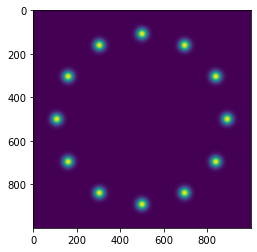

In [84]:
import numpy as np
xrange = np.linspace(-3, 3, 1000)
yrange = np.linspace(-3, 3, 1000)

X, Y = np.meshgrid(xrange, yrange)

func = sp.lambdify((x,y), model)

img = func(X, Y)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(img)

In [13]:
%%timeit
sp.symbols(['x'])

4.16 µs ± 25.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
